## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# regular libs
import os
from copy import deepcopy
import cv2
import numpy as np
from PIL import Image
import random
from concurrent.futures import ThreadPoolExecutor
import re

# plots, visualization
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

# tqdm
from tqdm.notebook import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# ai libs
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%load_ext tensorboard

CHECKPOINT_PATH = "saved_models"
NUM_WORKERS = os.cpu_count()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

<ipython-input-2-9f7630b15a39>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

In [ ]:
#pytorch lightning

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

## Data

In [ ]:
class DERMOGEN_SequenceDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        images = self.image_list[idx]
        if self.transform:
              images = (self.transform(images[0]), self.transform(images[1]))

        real = images[1]
        condition = images[0]

        return real, condition

In [ ]:
from sequence_loader import read_sequences

SEQUENCE_FOLDER = '/content/drive/MyDrive/Sekwencje_normalized'

sequences = read_sequences(SEQUENCE_FOLDER)

  0%|          | 0/1284 [00:00<?, ?it/s]

  0%|          | 0/3452 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [ ]:
import os

# Ścieżki do folderów z obrazami
folder_path1 = '/content/drive/MyDrive/Sekwencje_normalized_flatten'
folder_path2 = 'pix2pix_res_augmented/'

# Liczenie liczby plików w każdym folderze
num_files_path1 = len([name for name in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, name))])
num_files_path2 = len([name for name in os.listdir(folder_path2) if os.path.isfile(os.path.join(folder_path2, name))])

print(f'Liczba plików w folderze {folder_path1}: {num_files_path1}')
print(f'Liczba plików w folderze {folder_path2}: {num_files_path2}')

Liczba plików w folderze /content/drive/MyDrive/Sekwencje_normalized_flatten: 2359
Liczba plików w folderze pix2pix_res_augmented/: 0


In [ ]:
import os
import shutil

def flatten_folders(root_folder, flatten_folder):
    # Tworzymy folder docelowy, jeśli nie istnieje
    if not os.path.exists(flatten_folder):
        os.makedirs(flatten_folder)

    # Przechodzimy przez wszystkie foldery i pliki w root_folder
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            # Sprawdzamy, czy plik jest zdjęciem (można zmodyfikować warunek)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(dirpath, filename)
                # Kopiujemy plik do folderu flatten_folder
                shutil.copy(src_path, flatten_folder)
                print(f"Skopiowano: {src_path}")

if __name__ == "__main__":
    root_folder = '/content/drive/MyDrive/Sekwencje_normalized'  # główny folder, w którym są podfoldery z zdjęciami
    flatten_folder = '/content/drive/MyDrive/Sekwencje_normalized_flatten_'  # folder, do którego kopiujemy zdjęcia

    flatten_folders(root_folder, flatten_folder)

Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/7/7_1.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/7/7_2.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/7/7_3.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/7/7_5.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/7/7_4.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/5/5_5.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/5/5_3.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/5/5_4.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/5/5_1.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/5/5_2.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/3/3_5.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/3/3_2.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/3/3_4.jpg
Skopiowano: /content/drive/MyDrive/Sekwencje_normalized/182/3/3_3.jpg
Skopiowano: /content

In [ ]:
for root, _, files in tqdm(list(os.walk('/content/drive/MyDrive/Last_one'))[1:]):
            for filename in files:
                match = re.match(r'(\d+)_(\d+)\.jpg', filename)
                if match:
                   print(root, filename)

In [ ]:
def generate_image_pairs(sequences):
    pairs = []
    for sequence in sequences:
      images = sequence.images

      for i in range(len(images) - 1):
          pairs.append((images[i], images[i + 1]))

    return pairs

pairs = generate_image_pairs(sequences)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(256), transforms.ToTensor()]) #transforms.Normalize((0.5,), (0.5,))])

In [ ]:
dataset = DERMOGEN_SequenceDataset(pairs, transform)

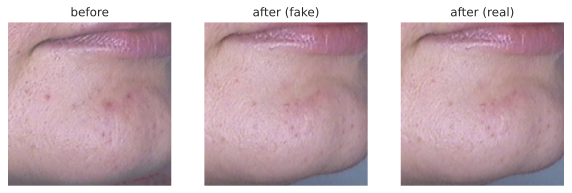

In [ ]:
def display(cond, fake, real):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    for i, (img, label) in enumerate(zip([cond, fake, real], ["before", "after (fake)", "after (real)"])):
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(label)
        ax[i].axis('off')

display(dataset[0][1], dataset[0][0], dataset[0][0])

## Model

In [ ]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [ ]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [ ]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [ ]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [ ]:
class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200):

        super().__init__()
        self.save_hyperparameters()

        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        #self.gen = self.gen.apply(_weights_init)
        #self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()
        self.automatic_optimization = False

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))

        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)

        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx):
        real, condition = batch
        real, condition = real.to(device), condition.to(device)
        disc_opt, gen_opt = self.optimizers()

        disc_loss = self._disc_step(real, condition)
        self.log('PatchGAN Loss', disc_loss)

        disc_opt.zero_grad()
        self.manual_backward(disc_loss)
        disc_opt.step()

        gen_loss = self._gen_step(real, condition)
        self.log('Generator Loss', gen_loss)
        gen_opt.zero_grad()
        self.manual_backward(gen_loss)
        gen_opt.step()

     #   if self.current_epoch%1 == 0 and batch_idx == 0:
      #       fake = self.gen(condition)
       #      display(condition[0].detach().cpu(), fake[0].detach().cpu(), real[0].detach().cpu())
        #     plt.show()

## Training

In [ ]:
# training with lightning
def train_pix2pix(config, dataset, check_pretrained=True):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'Pix2Pix_logs'),
                         accelerator="gpu" if str(config.device).startswith("cuda") else "cpu",
                         devices=1,
                         enable_checkpointing=True,
                         max_epochs=config.max_epochs
                        )
    trainer.logger._default_hp_metric = None

    model_file = os.path.join(CHECKPOINT_PATH, 'Pix2Pix_last_one.ckpt')
    if check_pretrained and os.path.isfile(model_file):
        print(f'Found pretrained model at {model_file}, loading...')

        model = Pix2Pix(3, 3, config.lr, config.lambda_recon)
        model.load_state_dict(torch.load(model_file))
    else:
        dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

        model = Pix2Pix(3, 3, config.lr, config.lambda_recon)
        trainer.fit(model, dataloader)
        torch.save(model.state_dict(), model_file)

    return model

In [ ]:
##### class for params
class HParams:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = {
    "batch_size": 128,
    "lr": 0.0002,
    "lambda_recon": 200,
    "max_epochs": 500,
    "device": device
}

train_config = HParams(**config)

In [ ]:
pix2pix = train_pix2pix(train_config, dataset, True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 54.4 M
1 | patch_gan             | PatchGAN          | 2.8 M 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.713   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.71 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [ ]:
pip install pillow

In [ ]:
pip install opencv-python

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageFilter
from PIL import ImageEnhance

# def sharpen_image_pil(image_tensor, factor=6.0):
#     image = transforms.ToPILImage()(image_tensor.cpu())
#     enhancer = ImageEnhance.Sharpness(image)
#     sharpened_image = enhancer.enhance(factor)  # factor > 1.0 increases sharpness
#     return transforms.ToTensor()(sharpened_image).to(device)

#cv2
def sharpen_image_pil(image_tensor):
    image = transforms.ToPILImage()(image_tensor.cpu())
    image_np = np.array(image)

    # Tworzenie kernela wyostrzającego
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])

    sharpened_image_np = cv2.filter2D(image_np, -1, kernel)
    sharpened_image = Image.fromarray(sharpened_image_np)

    return transforms.ToTensor()(sharpened_image).to(device)

def generate_sequence_sharpened(model, sequence, sequence_len=5, show=True):
    results = []
    model.eval()
    model = model.to(device)

    if show:
        fig, ax = plt.subplots(1, sequence_len, figsize=(10, 5))
        ax[0].imshow(sequence.images[0])
        ax[0].axis('off')

    # Ensure the initial image is copied to avoid negative stride issues
    current_img = transform(sequence.images[0].copy()).unsqueeze(0).to(device)  # Add unsqueeze(0) to add a batch dimension
    for i in range(1, sequence_len):
        current_img = model.gen(current_img)
        # Ensure current_img is contiguous before further processing
        current_img = current_img.contiguous()
        # Apply sharpening and ensure the result is also contiguous
        current_img = sharpen_image_pil(current_img[0])
        # Add batch dimension back if it was removed
        current_img = current_img.unsqueeze(0)
        results.append(current_img[0])

        if show:
            ax[i].imshow(current_img[0].detach().cpu().permute(1, 2, 0).contiguous())  # Ensure it's contiguous before permute()
            ax[i].axis('off')

    plt.tight_layout()
    if show:
        plt.show()
        sequence.show()

    return results

In [ ]:
def generate_sequence(model, sequence, sequence_len=5, show=True):
    results = []
    model.eval()
    model = model.to(device)
    if show:
        fig, ax = plt.subplots(1, sequence_len, figsize=(10, 5))

        ax[0].imshow(sequence.images[0])
        ax[0].axis('off')

    current_img = transform(sequence.images[0]).unsqueeze(0).to(device)
    for i in range(1, sequence_len):
        current_img = model.gen(current_img)
        results.append(current_img[0])
        if show:
            ax[i].imshow(current_img[0].detach().cpu().permute(1, 2, 0))
            ax[i].axis('off')

    plt.tight_layout()
    if show:
        plt.show()
        sequence.show()

    return results


In [ ]:
for i in range(len(sequences)):
    sequence = sequences[i]
    if len(sequence.images) > 3:
        print(i)

In [ ]:
pix2pix = Pix2Pix(3, 3, train_config.lr, train_config.lambda_recon)

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/"

In [ ]:
pix2pix.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'Pix2Pix_last_one_2.ckpt')))

<All keys matched successfully>

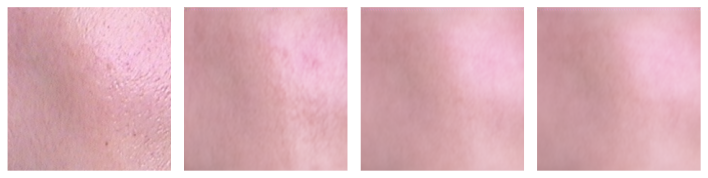

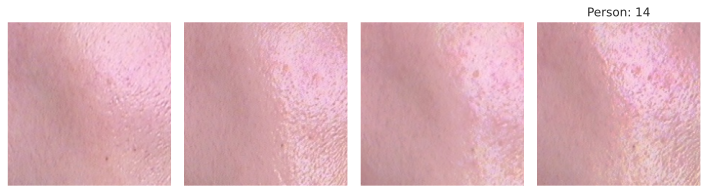

In [ ]:
_ = generate_sequence(pix2pix, sequences[49], 4)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


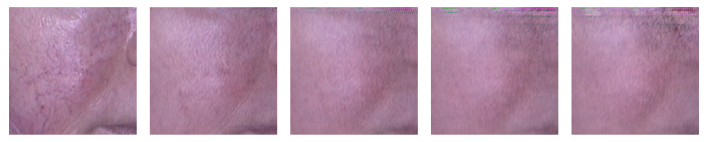

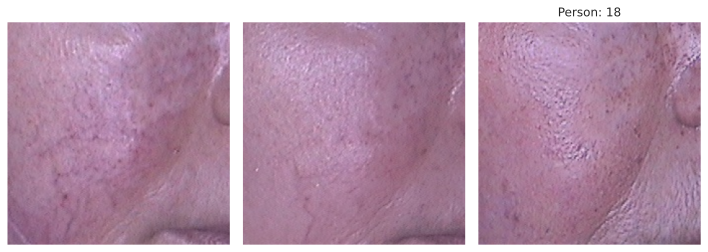

In [ ]:
_ = generate_sequence_sharpened(pix2pix, sequences[61])

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


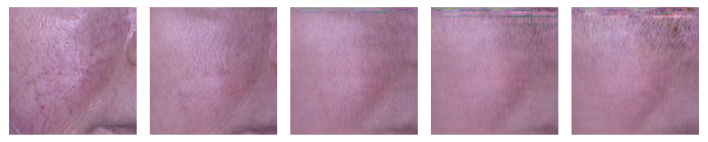

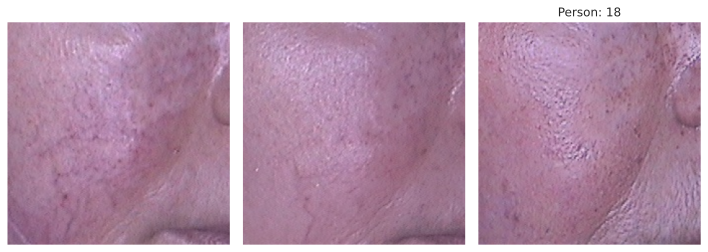

In [ ]:
_ = generate_sequence_sharpened(pix2pix, sequences[61])

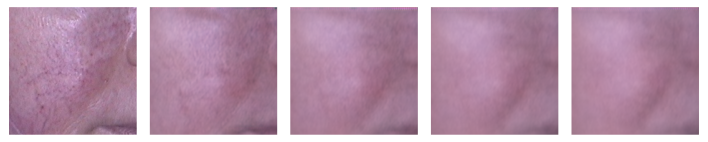

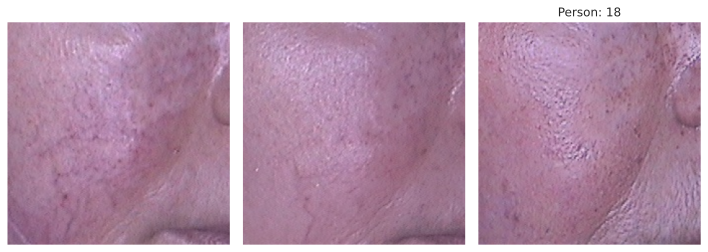

In [ ]:
_ = generate_sequence(pix2pix, sequences[61])

In [ ]:
def generate_image_pairs_with_generated(model, sequences, index):
    model.eval()
    model = model.to(device)
    pairs = []
    generated_images = []
    for sequence in sequences:
        images = sequence.images
        for i in range(len(images) - 1):
            if i > 0 and i <= index:
                image = model.gen(transform(sequence.images[i]).unsqueeze(0).to(device))[0].detach().cpu()
                pairs.append((image, images[i + 1]))
            else:
                pairs.append((images[i], images[i + 1]))

    return pairs

pairs = generate_image_pairs_with_generated(pix2pix, sequences, 1)
dataset = DERMOGEN_SequenceDataset(pairs, transform)
display(dataset[1][1], dataset[1][0], dataset[1][0])

In [ ]:
# for i in range(3):
#     trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f'Pix2Pix_logs_fitting_{i}'),
#                          accelerator="gpu" if str(device).startswith("cuda") else "cpu",
#                          devices=1,
#                          max_epochs=30
#                         )
#     pairs = generate_image_pairs_with_generated(pix2pix, sequences, i + 1)
#     dataset = DERMOGEN_SequenceDataset(pairs, transform)
#     dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
#     trainer.fit(pix2pix, dataloader)
#     generate_sequence(pix2pix, sequences[46])

# torch.save(pix2pix.state_dict(), os.path.join(CHECKPOINT_PATH, 'Pix2Pix_alt_best.ckpt'))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 54.4 M
1 | patch_gan             | PatchGAN          | 2.8 M 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
57.2 M    Trainable params
0         Non-trainable params
57.2 M    Total params
228.713   Total estimated model params size (MB)
/home/g254657/.local/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epo

Training: |          | 0/? [00:00<?, ?it/s]

### Evaluation

In [ ]:
pix2pix = Pix2Pix(3, 3, train_config.lr, train_config.lambda_recon)
pix2pix.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'Pix2Pix_last_one_2.ckpt')))

<All keys matched successfully>

In [ ]:
from generator_evaluate import calculate_similarity_metrics

# **Augemntowany - wyostrzony**

In [ ]:
def calc_all(model):
    max_len = max(len(sequence.images) for sequence in sequences)

    all_metrics = {'mse': [[] for _ in range(max_len)],
                   'psnr': [[] for _ in range(max_len)],
                   'ssim': [[] for _ in range(max_len)],
                   'correlation': [[] for _ in range(max_len)],
                   'histogram_diff': [[] for _ in range(max_len)]}

    os.makedirs("pix2pix_res_augmented_sharpened", exist_ok=True)

    for id1, sequence in tqdm(enumerate(sequences)):
        results = generate_sequence_sharpened(model, sequence, len(sequence.images), show=False)
        for id2, (generated, real) in enumerate(zip(results, sequence.images[1:])):
            # print(generated.shape)
            generated_resized = (255 * generated).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
            cv2.imwrite(f"pix2pix_res_augmented_sharpened/{id1}_{id2}.jpg", generated_resized)
            mse, psnr, ssim, correlation, histogram_diff = calculate_similarity_metrics(generated_resized, cv2.resize(real, (256, 256)))

            all_metrics['mse'][id2].append(mse)
            all_metrics['psnr'][id2].append(psnr)
            all_metrics['ssim'][id2].append(ssim)
            all_metrics['correlation'][id2].append(correlation)
            all_metrics['histogram_diff'][id2].append(histogram_diff)

    print("Mean metrics for each id2:")
    for id2 in range(max_len):
        print(f"id2={id2}:")
        for metric, values in all_metrics.items():
            print(f"{metric}: {round(np.mean(values[id2]), 3)}")
        print()

    print("\nOverall mean metrics:")
    for metric, values in all_metrics.items():
        print(f"{metric}: {round(np.mean([np.mean(sublist) for sublist in values]), 3)}")

calc_all(pix2pix)

0it [00:00, ?it/s]

Mean metrics for each id2:
id2=0:
mse: 32.159
psnr: 33.34
ssim: 0.723
correlation: 0.909
histogram_diff: 3688.623

id2=1:
mse: 54.042
psnr: 30.909
ssim: 0.587
correlation: 0.798
histogram_diff: 11485.273

id2=2:
mse: 59.686
psnr: 30.467
ssim: 0.57
correlation: 0.742
histogram_diff: 16411.09

id2=3:
mse: 63.036
psnr: 30.217
ssim: 0.567
correlation: 0.722
histogram_diff: 24439.736

id2=4:
mse: 66.463
psnr: 29.962
ssim: 0.572
correlation: 0.726
histogram_diff: 23733.399

id2=5:
mse: 69.172
psnr: 29.779
ssim: 0.53
correlation: 0.7
histogram_diff: 22862.062

id2=6:
mse: 67.656
psnr: 29.857
ssim: 0.57
correlation: 0.692
histogram_diff: 41530.296

id2=7:
mse: 67.145
psnr: 29.878
ssim: 0.633
correlation: 0.798
histogram_diff: 83130.036

id2=8:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


Overall mean metrics:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [ ]:
!python3 -m pytorch_fid /content/drive/MyDrive/Sekwencje_normalized_flatten/ pix2pix_res_augmented_sharpened/

100% 48/48 [00:35<00:00,  1.34it/s]
100% 48/48 [00:10<00:00,  4.52it/s]
FID:  283.1482343235824


# **Augmentowany**

In [ ]:
def calc_all(model):
    max_len = max(len(sequence.images) for sequence in sequences)

    all_metrics = {'mse': [[] for _ in range(max_len)],
                   'psnr': [[] for _ in range(max_len)],
                   'ssim': [[] for _ in range(max_len)],
                   'correlation': [[] for _ in range(max_len)],
                   'histogram_diff': [[] for _ in range(max_len)]}

    os.makedirs("pix2pix_res_augmented", exist_ok=True)

    for id1, sequence in tqdm(enumerate(sequences)):
        results = generate_sequence(model, sequence, len(sequence.images), show=False)
        for id2, (generated, real) in enumerate(zip(results, sequence.images[1:])):
            # print(generated.shape)
            generated_resized = (255 * generated).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
            cv2.imwrite(f"pix2pix_res_augmented/{id1}_{id2}.jpg", generated_resized)
            mse, psnr, ssim, correlation, histogram_diff = calculate_similarity_metrics(generated_resized, cv2.resize(real, (256, 256)))

            all_metrics['mse'][id2].append(mse)
            all_metrics['psnr'][id2].append(psnr)
            all_metrics['ssim'][id2].append(ssim)
            all_metrics['correlation'][id2].append(correlation)
            all_metrics['histogram_diff'][id2].append(histogram_diff)

    print("Mean metrics for each id2:")
    for id2 in range(max_len):
        print(f"id2={id2}:")
        for metric, values in all_metrics.items():
            print(f"{metric}: {round(np.mean(values[id2]), 3)}")
        print()

    print("\nOverall mean metrics:")
    for metric, values in all_metrics.items():
        print(f"{metric}: {round(np.mean([np.mean(sublist) for sublist in values]), 3)}")

calc_all(pix2pix)


0it [00:00, ?it/s]

Mean metrics for each id2:
id2=0:
mse: 24.163
psnr: 34.597
ssim: 0.782
correlation: 0.932
histogram_diff: 12300.453

id2=1:
mse: 47.158
psnr: 31.536
ssim: 0.675
correlation: 0.833
histogram_diff: 29312.652

id2=2:
mse: 53.59
psnr: 30.965
ssim: 0.661
correlation: 0.78
histogram_diff: 30281.886

id2=3:
mse: 58.512
psnr: 30.567
ssim: 0.655
correlation: 0.757
histogram_diff: 43047.345

id2=4:
mse: 61.773
psnr: 30.307
ssim: 0.67
correlation: 0.76
histogram_diff: 42078.577

id2=5:
mse: 64.505
psnr: 30.108
ssim: 0.619
correlation: 0.735
histogram_diff: 37536.558

id2=6:
mse: 62.292
psnr: 30.233
ssim: 0.65
correlation: 0.724
histogram_diff: 52720.115

id2=7:
mse: 61.438
psnr: 30.275
ssim: 0.734
correlation: 0.838
histogram_diff: 62322.548

id2=8:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


Overall mean metrics:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install scipy==1.11.1

  Using cached scipy-1.11.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


# **FID nie działa**

In [ ]:
!python3 -m pytorch_fid /content/drive/MyDrive/Sekwencje_normalized_flatten/ pix2pix_res_augmented/

100% 48/48 [00:37<00:00,  1.29it/s]
100% 48/48 [00:10<00:00,  4.54it/s]
FID:  251.47901598143002


In [ ]:
pix2pix.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'Pix2Pix_best.ckpt')))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/saved_models/Pix2Pix_best.ckpt'

In [ ]:
def calc_all(model):
    max_len = max(len(sequence.images) for sequence in sequences)

    all_metrics = {'mse': [[] for _ in range(max_len)],
                   'psnr': [[] for _ in range(max_len)],
                   'ssim': [[] for _ in range(max_len)],
                   'correlation': [[] for _ in range(max_len)],
                   'histogram_diff': [[] for _ in range(max_len)]}

    os.makedirs("pix2pix_res", exist_ok=True)

    for id1, sequence in tqdm(enumerate(sequences)):
        results = generate_sequence(model, sequence, len(sequence.images), show=False)
        for id2, (generated, real) in enumerate(zip(results, sequence.images[1:])):
            generated_resized = (255 * generated).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
            cv2.imwrite(f"pix2pix_res/{id1}_{id2}.jpg", generated_resized)
            mse, psnr, ssim, correlation, histogram_diff = calculate_similarity_metrics(generated_resized, cv2.resize(real, (256, 256)))

            all_metrics['mse'][id2].append(mse)
            all_metrics['psnr'][id2].append(psnr)
            all_metrics['ssim'][id2].append(ssim)
            all_metrics['correlation'][id2].append(correlation)
            all_metrics['histogram_diff'][id2].append(histogram_diff)

    print("Mean metrics for each id2:")
    for id2 in range(max_len):
        print(f"id2={id2}:")
        for metric, values in all_metrics.items():
            print(f"{metric}: {round(np.mean(values[id2]), 3)}")
        print()

    print("\nOverall mean metrics:")
    for metric, values in all_metrics.items():
        print(f"{metric}: {round(np.mean([np.mean(sublist) for sublist in values]), 3)}")

calc_all(pix2pix)

# **Zwykły**

In [ ]:
calc_all(pix2pix)
!python3 -m pytorch_fid Sekwencje_normalized_flatten/ pix2pix_res/

0it [00:00, ?it/s]

Mean metrics for each id2:
id2=0:
mse: 23.228
psnr: 34.681
ssim: 0.784
correlation: 0.929
histogram_diff: 17350.015

id2=1:
mse: 43.597
psnr: 31.861
ssim: 0.717
correlation: 0.851
histogram_diff: 44328.556

id2=2:
mse: 50.396
psnr: 31.234
ssim: 0.693
correlation: 0.808
histogram_diff: 54002.595

id2=3:
mse: 56.061
psnr: 30.775
ssim: 0.688
correlation: 0.783
histogram_diff: 68294.254

id2=4:
mse: 61.148
psnr: 30.351
ssim: 0.697
correlation: 0.77
histogram_diff: 69180.225

id2=5:
mse: 61.268
psnr: 30.339
ssim: 0.653
correlation: 0.769
histogram_diff: 82122.265

id2=6:
mse: 61.9
psnr: 30.242
ssim: 0.673
correlation: 0.74
histogram_diff: 84242.474

id2=7:
mse: 61.096
psnr: 30.299
ssim: 0.756
correlation: 0.868
histogram_diff: 115956.51

id2=8:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


Overall mean metrics:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan
100%|███████████████████████████████████████████| 48/48 [00:04<00:00, 10.62it/s]
FID:  309.438

# **Zwykły wyostrzony**

In [ ]:
pix2pix.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'Pix2Pix_best.ckpt')))

<All keys matched successfully>

In [ ]:
def calc_all(model):
    max_len = max(len(sequence.images) for sequence in sequences)

    all_metrics = {'mse': [[] for _ in range(max_len)],
                   'psnr': [[] for _ in range(max_len)],
                   'ssim': [[] for _ in range(max_len)],
                   'correlation': [[] for _ in range(max_len)],
                   'histogram_diff': [[] for _ in range(max_len)]}

    os.makedirs("pix2pix_res_norm_sharpened", exist_ok=True)

    for id1, sequence in tqdm(enumerate(sequences)):
        results = generate_sequence_sharpened(model, sequence, len(sequence.images), show=False)
        for id2, (generated, real) in enumerate(zip(results, sequence.images[1:])):
            # print(generated.shape)
            generated_resized = (255 * generated).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
            cv2.imwrite(f"pix2pix_res_norm_sharpened/{id1}_{id2}.jpg", generated_resized)
            mse, psnr, ssim, correlation, histogram_diff = calculate_similarity_metrics(generated_resized, cv2.resize(real, (256, 256)))

            all_metrics['mse'][id2].append(mse)
            all_metrics['psnr'][id2].append(psnr)
            all_metrics['ssim'][id2].append(ssim)
            all_metrics['correlation'][id2].append(correlation)
            all_metrics['histogram_diff'][id2].append(histogram_diff)

    print("Mean metrics for each id2:")
    for id2 in range(max_len):
        print(f"id2={id2}:")
        for metric, values in all_metrics.items():
            print(f"{metric}: {round(np.mean(values[id2]), 3)}")
        print()

    print("\nOverall mean metrics:")
    for metric, values in all_metrics.items():
        print(f"{metric}: {round(np.mean([np.mean(sublist) for sublist in values]), 3)}")

calc_all(pix2pix)

0it [00:00, ?it/s]

Mean metrics for each id2:
id2=0:
mse: 29.442
psnr: 33.582
ssim: 0.743
correlation: 0.896
histogram_diff: 2518.322

id2=1:
mse: 49.98
psnr: 31.228
ssim: 0.634
correlation: 0.776
histogram_diff: 6541.631

id2=2:
mse: 58.265
psnr: 30.555
ssim: 0.57
correlation: 0.671
histogram_diff: 7447.682

id2=3:
mse: 64.7
psnr: 30.094
ssim: 0.526
correlation: 0.603
histogram_diff: 6932.309

id2=4:
mse: 70.954
psnr: 29.675
ssim: 0.474
correlation: 0.552
histogram_diff: 7502.958

id2=5:
mse: 75.926
psnr: 29.371
ssim: 0.397
correlation: 0.505
histogram_diff: 8224.778

id2=6:
mse: 77.785
psnr: 29.254
ssim: 0.382
correlation: 0.436
histogram_diff: 10338.507

id2=7:
mse: 80.068
psnr: 29.124
ssim: 0.379
correlation: 0.5
histogram_diff: 12404.516

id2=8:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


Overall mean metrics:
mse: nan
psnr: nan
ssim: nan
correlation: nan
histogram_diff: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [ ]:
!python3 -m pytorch_fid /content/drive/MyDrive/Sekwencje_normalized_flatten pix2pix_res_norm_sharpened/

100% 48/48 [00:35<00:00,  1.34it/s]
100% 48/48 [00:10<00:00,  4.37it/s]
FID:  337.4485274034028
